In [1]:
import re
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
#load rental properties data
df = pd.read_json('../data/raw_data/properties.json').T

In [3]:
#drop any duplicate instances
df = df[~df.index.duplicated(keep = 'first')]

In [4]:
df.shape

(15236, 10)

In [5]:
df.tail()

,name,cost_text,coordinates,rooms,area,type,bond,features,unverified_features,desc
https://www.domain.com.au/16b-sandy-mount-avenue-inverloch-vic-3996-16006035,16B Sandy Mount Avenue Inverloch VIC 3996,$400.00 per week,"[-38.6340011, 145.725239]","[[2 Beds], [1 Bath], [1 Parking]]",None,House,1738,[],"[Built in wardrobes, Internal Laundry, Secure ...","[This spacious, two bedroom townhouse is perfe..."
https://www.domain.com.au/28-beachcomber-drive-inverloch-vic-3996-15920343,28 Beachcomber Drive Inverloch VIC 3996,$550 wk,"[-38.6412502, 145.7031282]","[[4 Beds], [2 Baths], []]",None,House,2390,[],"[Gas, Internal Laundry, Secure Parking, Furnis...",[The popular Beachcomber estate offers you mod...
https://www.domain.com.au/14-inverloch-parade-inverloch-vic-3996-16040296,14 Inverloch Parade Inverloch VIC 3996,$420 wk,"[-38.6287143, 145.7358082]","[[2 Beds], [1 Bath], []]",None,House,1820,"[Garden, Split System AC, Floorboards]","[Internal Laundry, Heating]","[This two bedroom, 1 bathroom home will surely..."
https://www.domain.com.au/inverloch-vic-3996-14434367,Inverloch VIC 3996,$475 wk,"[-38.6314613, 145.7293638]","[[3 Beds], [2 Baths], [1 Parking]]",None,House,2065,"[Ensuite, Garden, Split System AC, Outdoor Ent...",[Heating],[Neat 3 bedroom home located in the immaculate...
https://www.domain.com.au/64-dixon-street-inverloch-vic-3996-15951739,64 Dixon Street Inverloch VIC 3996,Contact Agent,"[-38.6313719, 145.717275]","[[1 Bed], [1 Bath], []]",200,House,200,[Solar panels],[],[- Street frontage with excellent exposure- Ap...


In [6]:
#extract postcode form the location of each property
df["postcode"] = df["name"].apply(lambda x : int(x[-4:]))

In [7]:
#extract suburb from the location of each property
df["suburb"] = df["name"].apply(lambda x : ' '.join(x.split()[-3:]))

In [8]:
#extract costs
df["costs"] = df["cost_text"].str.extract(r'(\d+\,*\d*)')

In [9]:
#drop "," in costs 
df["costs"] = df["costs"].apply(lambda x : str(x).replace(',', ''))

In [10]:
#extract number of bedrooms,number of bathrooms and number of parking spots

rooms = ["beds","baths","parking"]
for i in range(len(rooms)):
    df[rooms[i]] = df["rooms"].str[i].str[0].str.extract(r'(\d+)')
    df[rooms[i]] = df[rooms[i]].fillna(0)


In [11]:
#After extracting the features of number of beds, baths and parking, drop the "rooms" column
df.drop("rooms", axis=1, inplace=True)

In [12]:
#check all possible type of properties, we see that the type distribution is quite unbalanced, and obviously types like carspace, block of units
#are definitely not what we the objects we are analysing for
df.type.value_counts()

House                            7400
Apartment / Unit / Flat          5944
Townhouse                        1601
Studio                            183
Villa                              42
Acreage / Semi-Rural               15
Semi-Detached                      12
Terrace                             8
Carspace                            8
New Apartments / Off the Plan       6
Duplex                              4
Vacant land                         3
Retirement                          3
Rural                               2
Farm                                2
Penthouse                           1
New House & Land                    1
Block of Units                      1
Name: type, dtype: int64

In [13]:
#we only leave the type - House, Apartment/Unit/Flat and town house as they are the most general type and more suitable for modeling
df = df[(df["type"] == "House") | (df["type"] == "Apartment / Unit / Flat") | (df["type"] == "Townhouse")]

In [14]:
#convert data type to numeric
df[["costs", "bond","beds","baths","parking"]] = df[["costs","bond","beds","baths","parking"]].apply(pd.to_numeric,errors='coerce')

In [15]:
#check missing values
df.isnull().sum()

name                       0
cost_text                  0
coordinates                0
area                   14016
type                       0
bond                    1085
features                   0
unverified_features        0
desc                       0
postcode                   0
suburb                     0
costs                    336
beds                       0
baths                      0
parking                    0
dtype: int64

In [16]:
#As there are too many missing data for internal area, we may drop that feature
df.drop("area", axis=1, inplace=True)

In [17]:
#drop the instances with no rent 
df = df.dropna(subset=['costs','bond'])

In [18]:
#check missing values
df.isnull().sum()

name                   0
cost_text              0
coordinates            0
type                   0
bond                   0
features               0
unverified_features    0
desc                   0
postcode               0
suburb                 0
costs                  0
beds                   0
baths                  0
parking                0
dtype: int64

In [19]:
#check the distribution of costs $/pw
df["costs"].describe()

count     13596.000000
mean        535.466019
std        1262.489425
min           1.000000
25%         390.000000
50%         450.000000
75%         565.000000
max      120000.000000
Name: costs, dtype: float64

In [20]:
#After checking the properties on "www.domain.com.au" with rent pw below $100, we obtained that most of them are parking spots or storage sheds,
#and for those properties with rent above $6000, they are actually for business
#we drop those properties
df = df[(100 <= df.costs) & (df.costs <= 6000)]

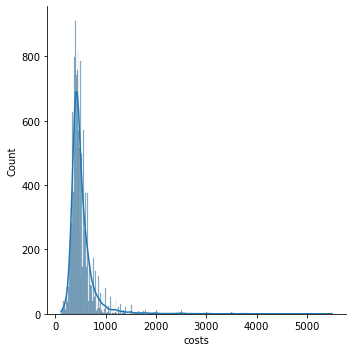

In [21]:
#display costs distribution
sns.displot(df, x="costs",kde = "True")

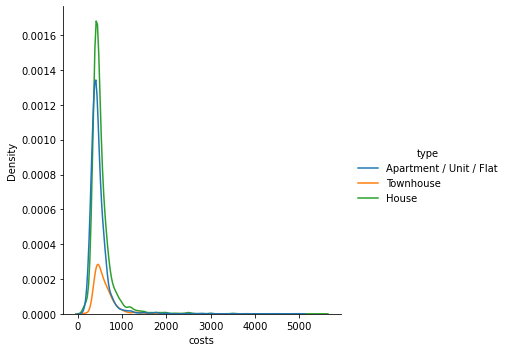

In [22]:
#display costs distribution by type
sns.displot(df, x="costs",hue="type", kind="kde")

In [23]:
#check the distribution of bond 
df["bond"].describe()

count     13506.000000
mean       2284.189101
std        2805.938686
min           4.000000
25%        1680.000000
50%        1955.000000
75%        2433.000000
max      282440.000000
Name: bond, dtype: float64

<AxesSubplot:xlabel='bond'>

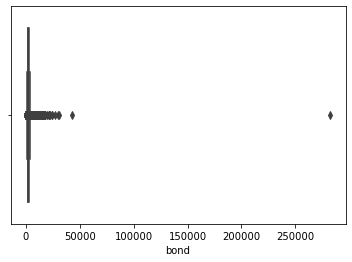

In [24]:
#display bond distribution
sns.boxplot(x = 'bond', data = df)

In [25]:
#remove outliers,since bond is normally up to four weeks' rent in australia
df = df[(500 <= df.bond) & (df.bond <= 25000)]

In [26]:
#display bond distribution
df["bond"].describe()

count    13425.000000
mean      2265.988752
std       1328.208979
min        500.000000
25%       1694.000000
50%       1955.000000
75%       2433.000000
max      24000.000000
Name: bond, dtype: float64

[Text(0.5, 1.0, 'Number of bedrooms per rental property')]

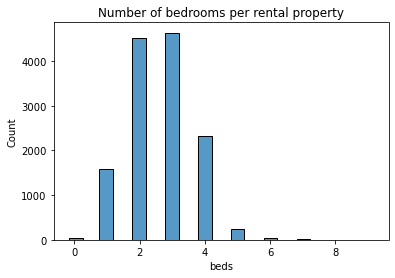

In [27]:
#check the distribution of number of bedrooms
sns.histplot(data=df, x="beds",shrink=5).set(title = "Number of bedrooms per rental property")

[Text(0.5, 1.0, 'Number of bathrooms per rental property')]

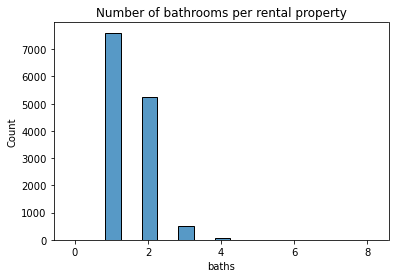

In [28]:
#check the distribution of number of bathrooms
sns.histplot(data=df, x="baths",shrink=5).set(title = "Number of bathrooms per rental property")

[Text(0.5, 1.0, 'Number of parking spot per rental property')]

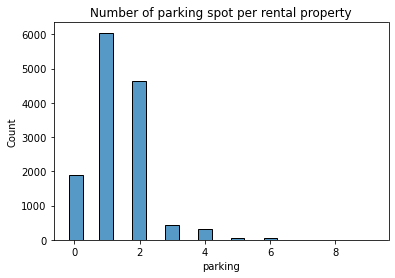

In [29]:
#check the distribution of number of parking spots
sns.histplot(data=df, x="parking",shrink=5).set(title = "Number of parking spot per rental property")

In [30]:
df.tail()

,name,cost_text,coordinates,type,bond,features,unverified_features,desc,postcode,suburb,costs,beds,baths,parking
https://www.domain.com.au/25a-veronica-street-inverloch-vic-3996-16006402,25A Veronica Street Inverloch VIC 3996,400 per week,"[-38.6428993, 145.7101579]",House,1738.0,"[Air conditioning, Close to schools, Furnished]","[Built in wardrobes, Heating]",[** APPLICATIONS ARE REQUIRED PRIOR TO VIEWING...,3996,Inverloch VIC 3996,400.0,3,1,1
https://www.domain.com.au/16b-sandy-mount-avenue-inverloch-vic-3996-16006035,16B Sandy Mount Avenue Inverloch VIC 3996,$400.00 per week,"[-38.6340011, 145.725239]",House,1738.0,[],"[Built in wardrobes, Internal Laundry, Secure ...","[This spacious, two bedroom townhouse is perfe...",3996,Inverloch VIC 3996,400.0,2,1,1
https://www.domain.com.au/28-beachcomber-drive-inverloch-vic-3996-15920343,28 Beachcomber Drive Inverloch VIC 3996,$550 wk,"[-38.6412502, 145.7031282]",House,2390.0,[],"[Gas, Internal Laundry, Secure Parking, Furnis...",[The popular Beachcomber estate offers you mod...,3996,Inverloch VIC 3996,550.0,4,2,0
https://www.domain.com.au/14-inverloch-parade-inverloch-vic-3996-16040296,14 Inverloch Parade Inverloch VIC 3996,$420 wk,"[-38.6287143, 145.7358082]",House,1820.0,"[Garden, Split System AC, Floorboards]","[Internal Laundry, Heating]","[This two bedroom, 1 bathroom home will surely...",3996,Inverloch VIC 3996,420.0,2,1,0
https://www.domain.com.au/inverloch-vic-3996-14434367,Inverloch VIC 3996,$475 wk,"[-38.6314613, 145.7293638]",House,2065.0,"[Ensuite, Garden, Split System AC, Outdoor Ent...",[Heating],[Neat 3 bedroom home located in the immaculate...,3996,Inverloch VIC 3996,475.0,3,2,1


In [31]:
#extract the costs pw by suburb
#as median is not significantly influenced by outliers
suburb_cost = df[["costs","suburb"]].groupby("suburb").median()
suburb_cost

,costs
suburb,
3004 VIC 3004,515.0
Abbotsford VIC 3067,580.0
Aberfeldie VIC 3040,445.0
Aintree VIC 3336,450.0
Albans VIC 3021,350.0
...,...
Yarram VIC 3971,550.0
Yarraville VIC 3013,550.0
Yarrawonga VIC 3730,530.0


In [32]:
#extract the number of properties by postcode
postcode_cost = df[["costs","postcode"]].groupby("postcode").median()
postcode_cost

,costs
postcode,
3000,550.0
3002,625.0
3003,520.0
3004,600.0
3006,550.0
...,...
3984,425.0
3987,550.0
3992,425.0


In [33]:
pop_postcode = pd.read_csv('../data/curated_data/pop_postcode.csv')

In [34]:
pop_postcode = pop_postcode.drop_duplicates()

In [35]:
pop_postcode.head(50)

,postcode,SA2,2021,Area Name,2026
0,3000,206041122.0,43823.0,Melbourne,"73,594"
1,3001,206041122.0,43823.0,Melbourne,"73,594"
2,3002,206041119.0,4962.0,East Melbourne,"6,519"
3,3003,206041127.0,0.0,West Melbourne,0
4,3004,206041126.0,23173.0,Southbank,"41,516"
5,3004,206041125.0,6542.0,South Yarra - West,"7,541"
7,3005,206041118.0,15942.0,Docklands,"24,820"
8,3006,206041126.0,23173.0,Southbank,"41,516"
9,3006,206051132.0,12330.0,South Melbourne,"23,032"
10,3008,206041118.0,15942.0,Docklands,"24,820"


In [36]:
df_new = pd.merge(df,pop_postcode,how='left')

In [37]:
len(df_new)

28370

In [38]:
df.to_csv('../data/curated_data/properties.csv',index = False)